# Classification of Citrus Diseases

> This notebook covers the necessary steps to experiment with a FLIM towards a classification problem. We will be focusing on Citrus Leaves diseases, investigating a FLIM encoder combined with fully connected layer to classify our images. Finally, we will replace fully connected layers by support vector machines (SVM). This approach enables us to train a pipeline end-to-end without backpropagation.

We will approach the following:

- FLIM Encoders
- Unbalanced data
- Augmentations
- Linear Layers
- Dropout
- Activations (ReLU)
- SoftMax
- Loss Function with L2 Regularization
- ConfusionMatrix
- Support Vector Machines (SVM)

# Dataset and Data Loader

In [1]:
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from random import shuffle
from skimage.color import lab2rgb
import json

In [2]:
data_path = Path("/home/john_doe/msc/2_datasets/citrus/citrus_leaves")
images_folder = data_path / Path("orig_aug")
classes_desc = data_path / Path("classes.txt")

arch_json = Path(
    "/home/john_doe/msc/3_repos/ift/demo/FLIM/notebooks_and_architectures/class_citrus/arch2d_class.json"
)

weights_path = Path(
"/home/john_doe/msc/3_repos/msc_repo/experiments/2_flim_activations/class_citrus/flim_data/model"
)

In [3]:
# Reads architecture dict to define our network
with open(arch_json, "r") as json_data:
    arch_description = json.load(json_data)

In [4]:
# Read classes to a dictionary
classes_dict = {}
with open(classes_desc, "r") as file:
    lines = file.readlines()
    for line in lines:
        class_id, class_description = line.strip().split(" ")
        classes_dict[int(class_id)] = class_description
        
print(classes_dict)

{1: 'blackspot', 2: 'canker', 3: 'greening', 4: 'healthy', 5: 'melanose'}


In [5]:
image_files = os.listdir(images_folder)
print(image_files[:10])

['000003_000145.png', '000004_000036.png', '000003_000063.png', '000003_000024.png', '000002_000107.png', '000001_000083.png', '000001_000158.png', '000004_000043.png', '000005_000096.png', '000002_000043.png']


Looking at image folders, we could see that images are organized as follows:

xxxxxx_yyyyyy.png

Where,

- xxxxxx stands for image class;
- yyyyyy stands for image id.

For example, 000003_000145.png stands for an image of class 3 (greening), and 000004_000036.png for an image of class 4 (healthy).

In [6]:
class_count = {1:0, 2:0, 3:0, 4:0, 5:0}

for image_file in image_files:
    image_class = int(image_file.split("_")[0])
    class_count[image_class] += 1
    
print(class_count)

{1: 171, 2: 163, 3: 204, 4: 174, 5: 112}


As we can see, some classes has more instances than others.

This is a problem of unbalanced data. We will need to tackle it during training.

Let us now implement our dataloader and dataset. As we have a different number of images for each class, we will separate 80% of each class for training, and 20% for testing.

In [7]:
images_by_class = {
    1:[], 2:[], 3:[], 4:[], 5:[]
}

for image_file in image_files:
    image_class = int(image_file.split("_")[0])
    images_by_class[image_class].append(image_file)

    
train_images_by_class = {}
test_images_by_class = {}

for class_id, class_images in images_by_class.items():
    n_train_images = int(0.8 * len(class_images))
    train_images_by_class[class_id] = class_images[:n_train_images]
    test_images_by_class[class_id] = class_images[n_train_images:]

# Merge images back into a single list
train_images = []
for images in train_images_by_class.values():
    train_images += images
shuffle(train_images)
test_images = []
for images in test_images_by_class.values():
    test_images += images
shuffle(test_images)

In [8]:
""" From our experiments, we saw that convolutional operations
were able to extract better features on LAB Space. So we need to 
enable conversion to LAB.
"""
def _labf(x):
    if x >= 8.85645167903563082e-3:
        return x ** (0.333333333333333)
    else:
        return (841.0 / 108.0) * (x) + (4.0 / 29.0)
    
def rgb2lab(image):
    norm_value = 255
    image = np.array(image)
    image = image / norm_value
    
    labf_v = np.vectorize(_labf)
    
    new_image = np.zeros_like(image)
    
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    X = (
        0.4123955889674142161 * R
        + 0.3575834307637148171 * G
        + 0.1804926473817015735 * B
    )
    Y = (
        0.2125862307855955516 * R
        + 0.7151703037034108499 * G
        + 0.07220049864333622685 * B
    )
    Z = (
        0.01929721549174694484 * R
        + 0.1191838645808485318 * G
        + 0.9504971251315797660 * B
    )
    
    X = labf_v(X / 0.950456)
    Y = labf_v(Y / 1.0)
    Z = labf_v(Z / 1.088754)
    
    new_image[:, :, 0] = 116 * Y - 16
    new_image[:, :, 1] = 500 * (X - Y)
    new_image[:, :, 2] = 200 * (Y - Z)
    
    new_image[:, :, 0] = new_image[:, :, 0] / 99.998337
    new_image[:, :, 1] = (new_image[:, :, 1] + 86.182236) / (86.182236 + 98.258614)
    new_image[:, :, 2] = (new_image[:, :, 2] + 107.867744) / (107.867744 + 94.481682)
    
    return new_image.astype(np.float32)

In [9]:
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps

In [10]:
class ClassificationDataset(Dataset):
    def __init__(
        self,
        images_folder: PosixPath, # Path to images
        images: List[str], # List of images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = [images_folder / Path(image) for image in images]
        
        if augmentation == True:
            self.transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR, 
                    fill=0
                ),
                #transforms.RandomPerspective(),
                #transforms.ElasticTransform(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                #transforms.ColorJitter(),
                transforms.GaussianBlur(3),
                rgb2lab,
                
                transforms.ToTensor()
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transforms = transforms.Compose([
                rgb2lab,
                transforms.ToTensor()
            ])
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        label_ = int(image_path.stem.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1
        
        image = self.transforms(
            Image.open(image_path)
        )
        label = torch.Tensor(label_one_hot)
        
        return image, label

In [11]:
classification_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=True
)
classification_dataloader = DataLoader(
    classification_dataset, batch_size=8, shuffle=True
)

sample_train_images, sample_train_labels = next(iter(classification_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 256, 256])
Labels shape =>  torch.Size([8, 5])


In [12]:
def visualize_random_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(16,8))
    for idx in range(8):
        image = batch_images[idx]
        image = image.permute(1, 2, 0)
        image = image.detach().cpu().numpy()
        image[:,:, 0] = image[:,:, 0] * 99.998337
        image[:,:, 1] = image[:,:, 1] * (86.182236 + 98.258614) - 86.182236
        image[:,:, 2] = image[:,:, 2] * (107.867744 + 94.481682) - 107.867744
        image = lab2rgb(image)
        label = batch_labels[idx]
        label = label.detach().cpu().numpy()
        label = np.argmax(label) + 1
        title = classes_dict[label]
        
        # Plot Data
        axes[idx//4][idx%4].set_yticks([]),axes[idx//4][idx%4].set_xticks([])
        axes[idx//4][idx%4].set_title(title)
        axes[idx//4][idx%4].imshow(image)

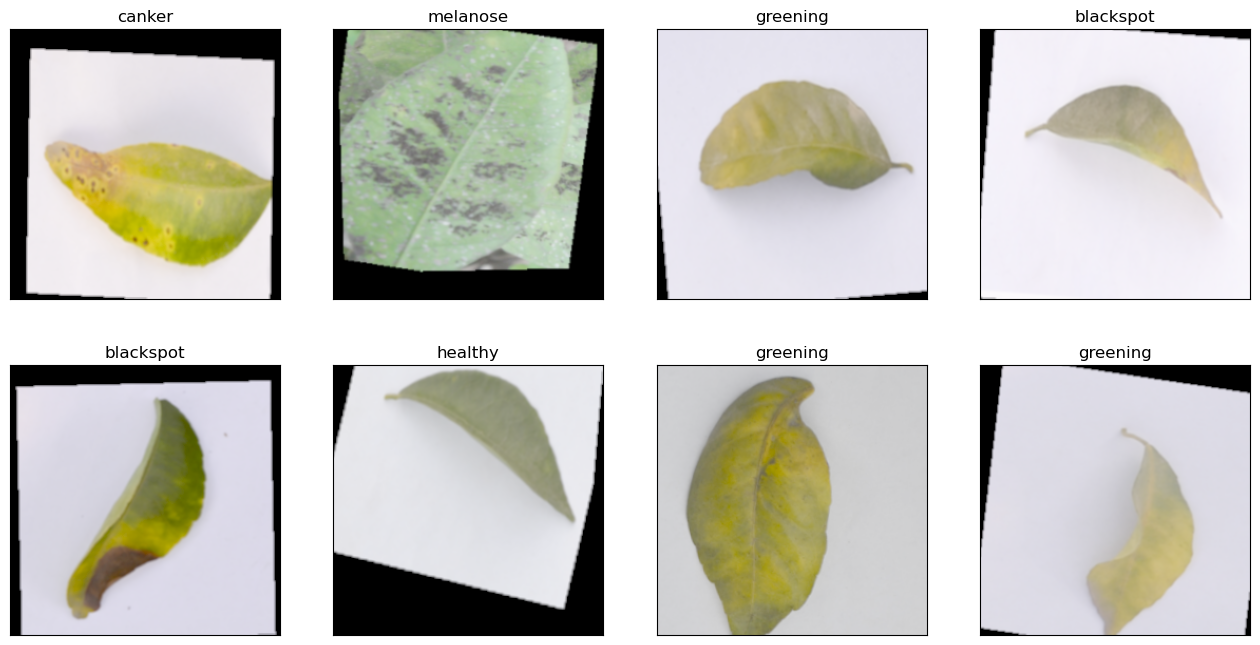

In [13]:
visualize_random_batch(classification_dataloader)

# Model

In [14]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

In [15]:
def conv(
        in_channels:int,
        out_channels:int,
        kernel_size:int,
        padding:int=1
) -> torch.nn.modules.container.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=1, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
    )

class ClassificationModel(nn.Module):
    def __init__(
        self, in_channels: int, # RGB or LAB -> 3 Channels
        n_kernels: List[int], # N Kernels by conv block
        kernel_sizes: List[int], # Kernel sizes by conv block
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        
        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # Classification Encoder        
        self.conv1 = conv(
            in_channels=in_channels, out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2
        )
        self.conv2 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2
        )
        self.conv3 = conv(
            in_channels=n_kernels[1], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],padding=kernel_sizes[2]//2
        )
        
        # Classification Decoder (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*32*n_kernels[2], out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )
        
        # Initialize weights (XAVIER)
        self._initialize_weights()
        
    def forward(self, x):
        # List to keep track of activations
        self.activations = []
        
        # Extract Features
        x = self.conv1(x)
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = self.conv3(x)
        self.activations.append(x)
        
        #Flattens input tensor into a 2D tensor
        x = torch.flatten(x, start_dim=1)
        
        y = self.classifier(x)
        
        return y
        
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=np.sqrt(2. / n))
                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()
                    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)
        
        image = Image.fromarray(image)
        if reshape:
            image = image.resize((256, 256), Image.Resampling.NEAREST)
        image.save(path)
        
    # Save encoder activations
    @torch.no_grad()
    def save_activations(
        self, epoch: int,
        data_loader: torch.utils.data.dataloader.DataLoader
    ) -> None:
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Saving activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        to_tensor = transforms.ToTensor()
        for image_path in tqdm(images_path):
            image_name = image_path.stem
            saving_path = activations_path / Path(image_name) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = to_tensor(rgb2lab(Image.open(image_path)))
            # Adds Batch Dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to("cuda")
            self.to("cuda")
            self.forward(image_data)
            
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]
                    
                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Save with the same shape as input
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )
                    
        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_loss"], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_accuracy"], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

Additionally, as we will use a FLIM Encoder as our U-Net encoder, we define methods to load FLIM Encoder's weight into the U-Net encoder.

In [16]:
def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")
    
    bias = np.array(bias).astype(np.float32)
    
    return bias

def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:
    kn = 1 # neutral element
    
    # Iterates over each kernel size
    for i in range(len(kernel_size)):
        kn = kn * kernel_size[i]
    
    mid_index = int(kn / 2) + 1
    
    weights = np.concatenate(
        (
            weights[in_channels: mid_index * in_channels],
            weights[0:in_channels],
            weights[mid_index * in_channels:]
        ),
        axis=0
    )
    
    return weights

def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)
    
    return weights

def load_FLIM_encoder(
        model: ClassificationModel, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]
) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)
    
    n_layers = arch_description["nlayers"]
    
    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"conv{n}")
        
        # Sets its biases
        bias_path = weights_path / Path(f"conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias
        
        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = weights.transpose()
        weights = weights.reshape(out_channels, kernel_size[1], kernel_size[0], in_channels).transpose(0, 3, 1, 2)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights
        
        in_channels = channels[n]

# Train Loop and Inference

In this section we will implement the following:

- Our training loop and our loss (with l2 regularization). It also enables freezing encoder weights and training with Learning Rate Scheduler.
- Our inference method, to save or predictions and show evaluation metrics
- Visualization of last layers, to verify if convolutions transforms our data into a hight-dimensional sparse space

In [17]:
from torch_snippets import optim, Report
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

In [18]:
# Loss Function with L2 Regularization
def criterion(model, preds, targets, loss_function):
    loss_scalar = loss_function(preds, targets)
    
    # Add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss_scalar += 0.0001 * l2_regularization # 0.0001 is the weight_decay
    # Compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1] # same as argmax
    target_labels = torch.max(targets, 1)[1] # same as argmax
    acc = torch.sum(pred_labels == target_labels)
    n = pred_labels.size(0)
    acc = acc/n
    
    return loss_scalar, acc

In [19]:
def train_loop(
    epochs, model, dataloader, lr, loss_function,
    n_save_activations=200, freeze_encoder=False, use_lr_scheduler=False
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = lr_scheduler.LinearLR(
            optimizer, start_factor=1e-2, end_factor=1, total_iters=100, verbose=False
        )
    model.to("cuda")
    logger = Report(epochs)
    
    # Freeze encoder weights
    if freeze_encoder:
        model.conv1.requires_grad_(False)
        model.conv1.trainable = False
        model.conv2.requires_grad_(False)
        model.conv2.trainable = False
        model.conv3.requires_grad_(False)
        model.conv3.trainable = False
    
    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader:
            model.train()
            image, ground_truth = batch
            image = image.to("cuda")
            ground_truth = ground_truth.to("cuda")
            prediction = model(image)
            optimizer.zero_grad()
            
            # Gets Loss and Accuracy
            loss, acc = criterion(model, prediction, ground_truth, loss_function)
            losses.append(loss)
            accuracies.append(acc)
            
            loss.backward()
            optimizer.step()
        
        # At the end of the epoch, we tach a step in our LR Scheduler
        if use_lr_scheduler:
            scheduler.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % n_save_activations) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

In [20]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [21]:
@torch.no_grad()
def predict_and_evaluate(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    dataset: str="test"
) -> None:
    images_path = data_loader.dataset.images_path
    preds_path = model.activations_path / Path(f"preds_{dataset}.csv")
    model.eval()
    
    preds_dict = {
        "image_filename": [],
        "ground_truth": [],
        "pred_label": [],
        "prediction": []
    }
    to_tensor = transforms.ToTensor()
    for image_path in tqdm(images_path):
        image_filename = image_path.stem
        ground_truth = int(image_filename.split("_")[0])
        
        image_data = to_tensor(rgb2lab(Image.open(image_path)))
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to("cuda")
        prediction = model(image_data).cpu().detach().numpy()[0]
        predicted_label = np.argmax(prediction) + 1
        
        preds_dict["image_filename"].append(image_filename)
        preds_dict["ground_truth"].append(ground_truth)
        preds_dict["pred_label"].append(predicted_label)
        preds_dict["prediction"].append(prediction)
        
    df = pd.DataFrame.from_dict(preds_dict)
    df.to_csv(preds_path, index=False)
    
    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()
    
    report = classification_report(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        target_names=list(classes_dict.values())
    )
    print(report)

In [22]:
from sklearn.manifold import TSNE
from collections import OrderedDict
from typing import Tuple, Dict

In [23]:
def get_each_output(
    model: ClassificationModel,
    x: torch.Tensor
) -> OrderedDict:
    # Empty dict
    output_by_layer = OrderedDict()
    
    # Saves CNN Outputs
    x = model.conv1(x)
    output_by_layer["cnn-1"] = x.clone().detach().cpu().numpy()
    x = model.conv2(x)
    output_by_layer["cnn-2"] = x.clone().detach().cpu().numpy()
    x = model.conv3(x)
    output_by_layer["cnn-3"] = x.clone().detach().cpu().numpy()
    
    #Flattens input tensor into a 2D tensor
    x = torch.flatten(x, start_dim=1)
    
    # Saves Classifier Outputs
    for layer_name, layer in model.classifier.named_children():
        x = layer.forward(x)
        output_by_layer[f"classifier-{layer_name}"] = x.clone().detach().cpu().numpy()
        
    return output_by_layer

def get_outputs(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader
) -> Tuple[OrderedDict, np.ndarray]:
    outputs_by_layer = None
    all_labels = None
    
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to("cuda")
        labels = labels.clone().detach().cpu().numpy()
        labels = np.argmax(labels, axis=1) + 1
        
        outputs = get_each_output(model, inputs)
        
        # save the outputs
        if outputs_by_layer == None:
            outputs_by_layer = outputs
            all_labels = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate(
                    (outputs_by_layer[layer], outputs[layer]),
                    axis=0
                )
            all_labels = np.concatenate((all_labels, labels))
            
    return outputs_by_layer, all_labels

def visualize_layers_output(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    classes_dict: Dict[int, str],
    dataset: str="test"
) -> None:
    print(f"[INFO] Generating visualizations for {dataset} dataset")
    tsne = TSNE(perplexity=15)
    outputs_by_layer, all_labels = get_outputs(model, data_loader)
    
    legends = [f"{value} ({key})" for key, value in classes_dict.items()]    
    
    # Projects each layer output into a 2D Space
    cmap = plt.get_cmap('tab10')
    for layer in outputs_by_layer:
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        embedded = tsne.fit_transform(output)
        
        for i_label in range(1, 6):
            filtered_embedded = embedded[all_labels==i_label]
            filtered_labels = all_labels[all_labels==i_label]
            points_color = np.array([list(cmap(i_label - 1))] * len(filtered_embedded))
            plt.scatter(
                filtered_embedded[:, 0], filtered_embedded[:, 1],
                c= points_color,
                label=legends[i_label - 1]
            )
        plt.legend(
            loc="lower center", bbox_to_anchor=(0.5, -0.2),
            ncol=3, fancybox=True, shadow=True
        )
        plt.axis("off")
        plt.title(layer)
        plt.show()
           

# Train Experiment

First, we will train our model under 3 configurations:

- Froozen encoder
- LR Fixed
- LR Scheduler

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 6.364  trn_accuracy: 0.435  (26.58s - 5289.31s remaining)
EPOCH: 2.000  trn_loss: 1.625  trn_accuracy: 0.568  (53.98s - 5344.23s remaining)
EPOCH: 3.000  trn_loss: 0.920  trn_accuracy: 0.649  (82.14s - 5393.82s remaining)
EPOCH: 4.000  trn_loss: 0.919  trn_accuracy: 0.652  (110.97s - 5437.35s remaining)
EPOCH: 5.000  trn_loss: 0.873  trn_accuracy: 0.651  (140.03s - 5461.30s remaining)
EPOCH: 6.000  trn_loss: 0.815  trn_accuracy: 0.687  (169.25s - 5472.26s remaining)
EPOCH: 7.000  trn_loss: 0.785  trn_accuracy: 0.708  (198.96s - 5485.53s remaining)
EPOCH: 8.000  trn_loss: 0.795  trn_accuracy: 0.675  (228.62s - 5486.83s remaining)
EPOCH: 9.000  trn_loss: 0.755  trn_accuracy: 0.714  (258.60s - 5488.15s remaining)
EPOCH: 10.000  trn_loss: 0.741  trn_accuracy: 0.717  (287.90s - 5470.08s remaining)
EPOCH: 11.000  trn_loss: 0.806  trn_accuracy: 0.696

100%|██████████| 657/657 [02:26<00:00,  4.48it/s]


EPOCH: 101.000  trn_loss: 0.501  trn_accuracy: 0.801  (3231.38s - 3167.39s remaining)
EPOCH: 102.000  trn_loss: 0.531  trn_accuracy: 0.809  (3264.28s - 3136.27s remaining)
EPOCH: 103.000  trn_loss: 0.510  trn_accuracy: 0.807  (3296.94s - 3104.89s remaining)
EPOCH: 104.000  trn_loss: 0.425  trn_accuracy: 0.854  (3329.55s - 3073.43s remaining)
EPOCH: 105.000  trn_loss: 0.509  trn_accuracy: 0.804  (3361.80s - 3041.63s remaining)
EPOCH: 106.000  trn_loss: 0.429  trn_accuracy: 0.842  (3393.85s - 3009.64s remaining)
EPOCH: 107.000  trn_loss: 0.513  trn_accuracy: 0.815  (3426.65s - 2978.30s remaining)
EPOCH: 108.000  trn_loss: 0.468  trn_accuracy: 0.851  (3458.75s - 2946.35s remaining)
EPOCH: 109.000  trn_loss: 0.521  trn_accuracy: 0.815  (3491.33s - 2914.78s remaining)
EPOCH: 110.000  trn_loss: 0.469  trn_accuracy: 0.816  (3523.52s - 2882.88s remaining)
EPOCH: 111.000  trn_loss: 0.441  trn_accuracy: 0.825  (3556.15s - 2851.33s remaining)
EPOCH: 112.000  trn_loss: 0.478  trn_accuracy: 0.828  

100%|██████████| 657/657 [00:28<00:00, 23.23it/s]


[INFO] Metrics for train dataset


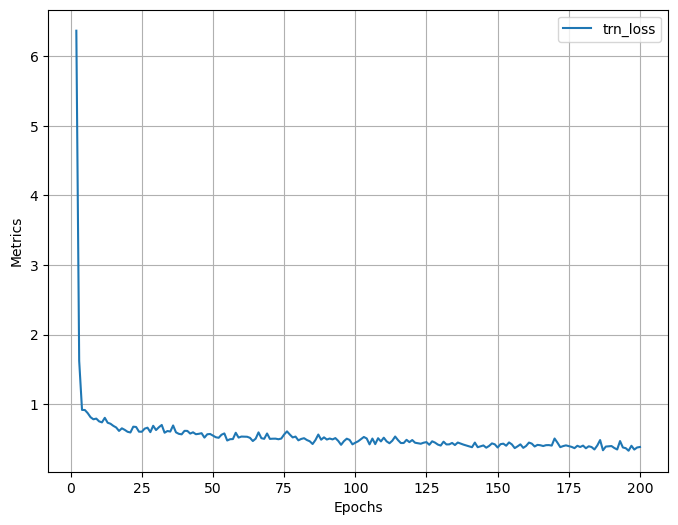

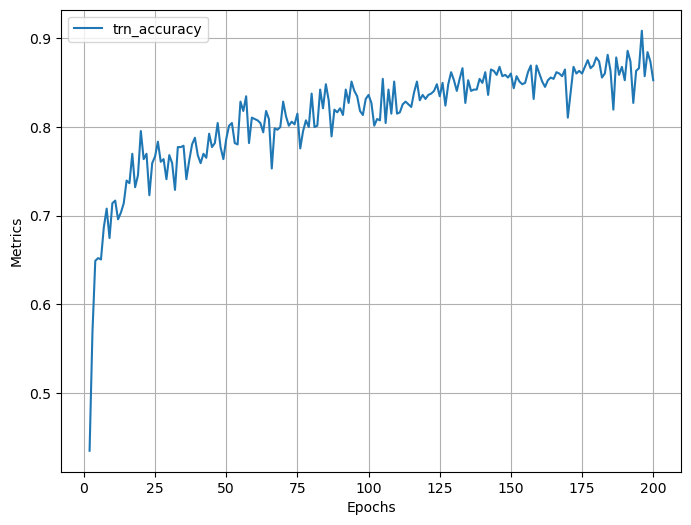

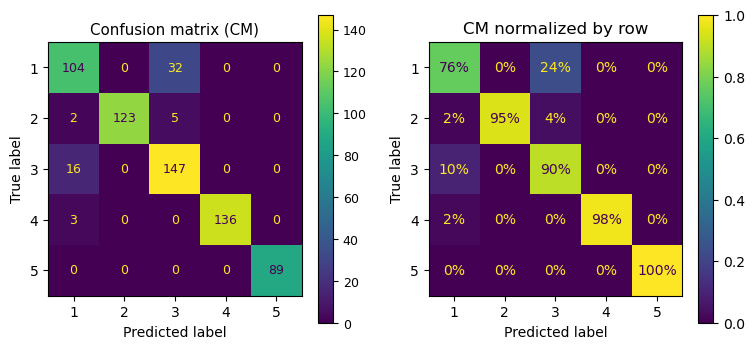

              precision    recall  f1-score   support

   blackspot       0.83      0.76      0.80       136
      canker       1.00      0.95      0.97       130
    greening       0.80      0.90      0.85       163
     healthy       1.00      0.98      0.99       139
    melanose       1.00      1.00      1.00        89

    accuracy                           0.91       657
   macro avg       0.93      0.92      0.92       657
weighted avg       0.92      0.91      0.91       657



100%|██████████| 167/167 [00:07<00:00, 21.77it/s]


[INFO] Metrics for test dataset


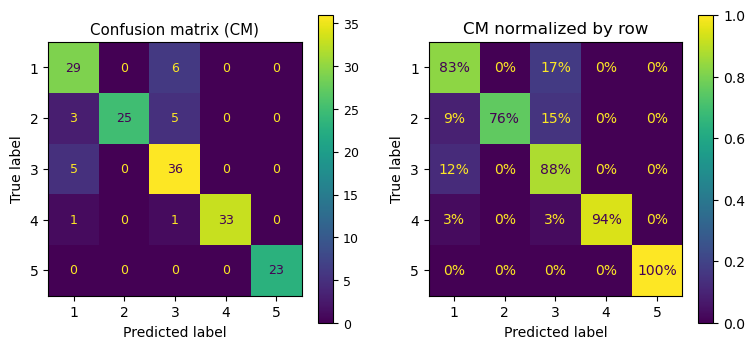

              precision    recall  f1-score   support

   blackspot       0.76      0.83      0.79        35
      canker       1.00      0.76      0.86        33
    greening       0.75      0.88      0.81        41
     healthy       1.00      0.94      0.97        35
    melanose       1.00      1.00      1.00        23

    accuracy                           0.87       167
   macro avg       0.90      0.88      0.89       167
weighted avg       0.89      0.87      0.88       167

[INFO] Generating visualizations for Train dataset


100%|██████████| 83/83 [00:47<00:00,  1.75it/s]


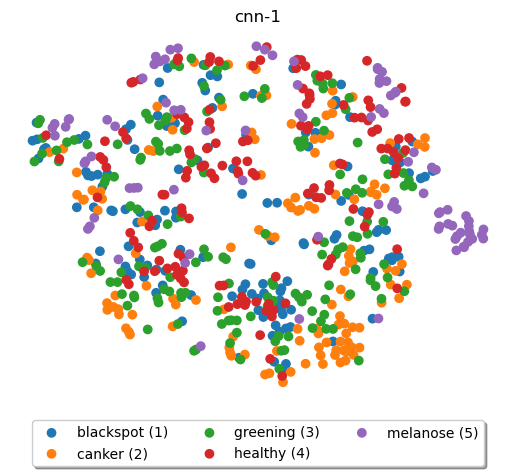

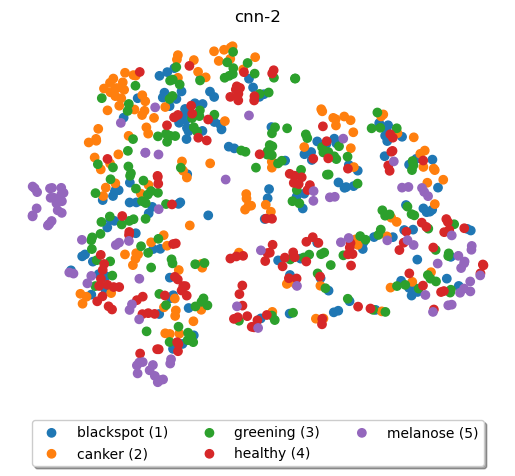

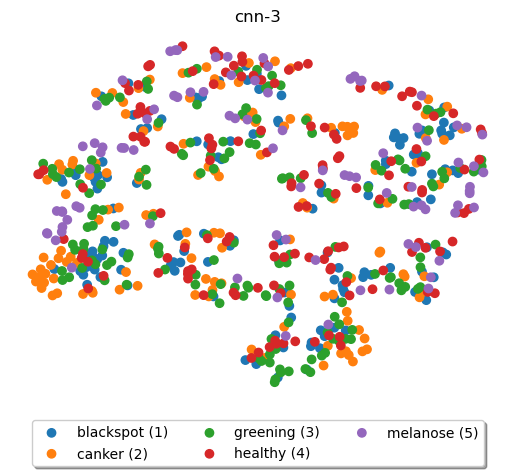

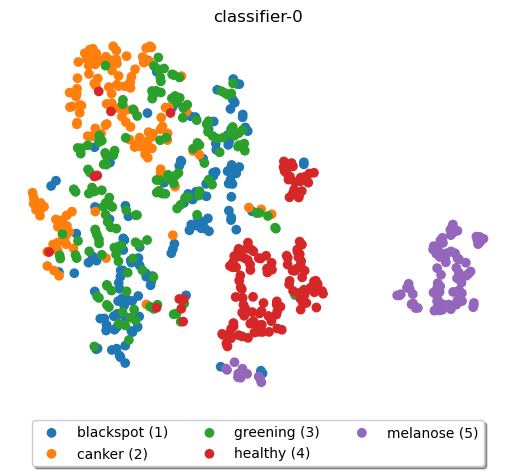

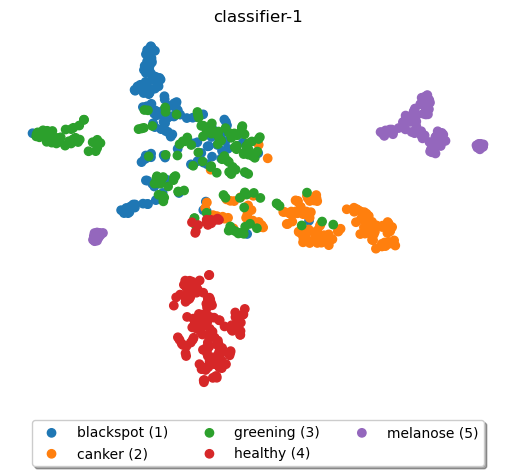

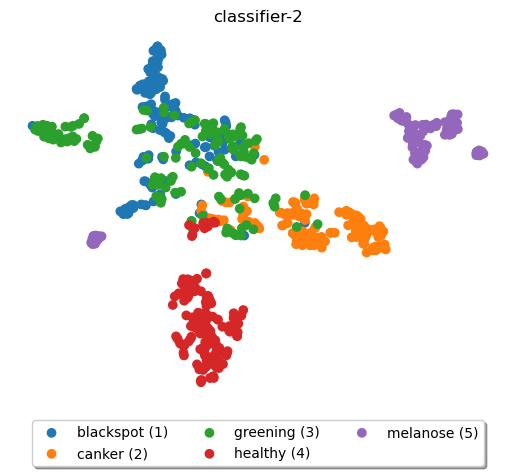

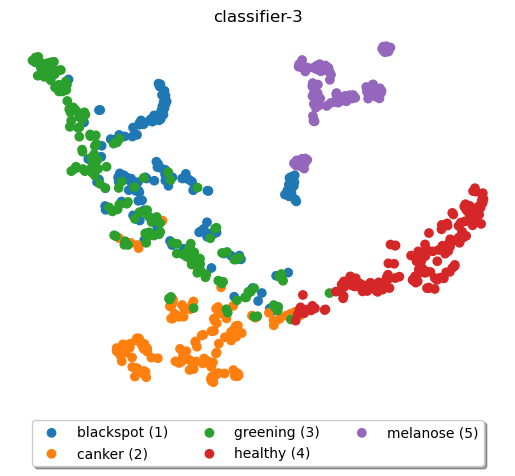

[INFO] Generating visualizations for Test dataset


100%|██████████| 167/167 [00:15<00:00, 10.95it/s]


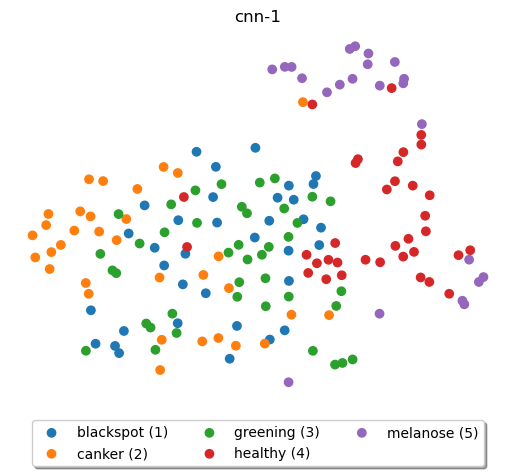

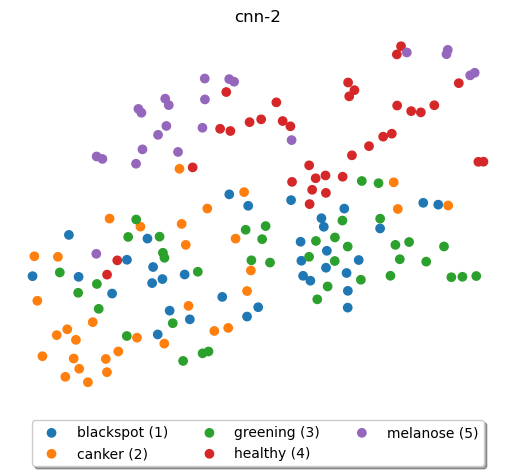

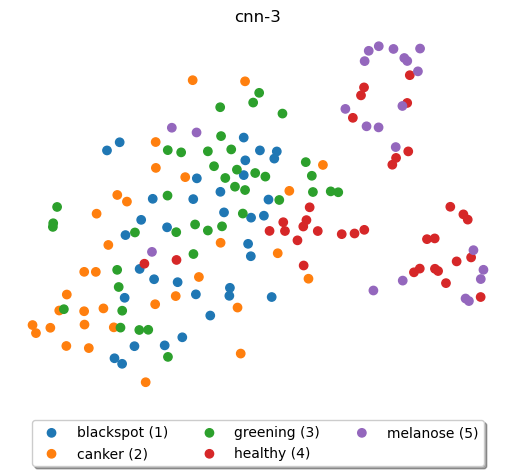

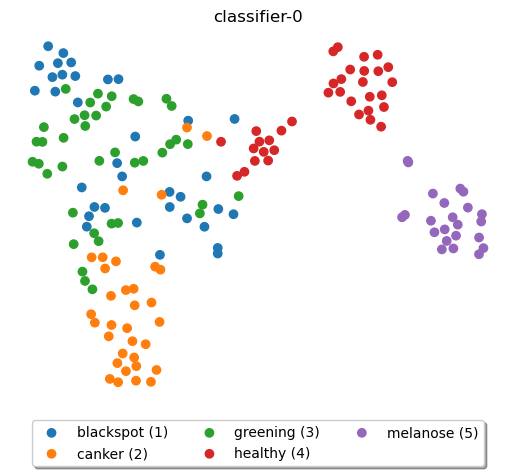

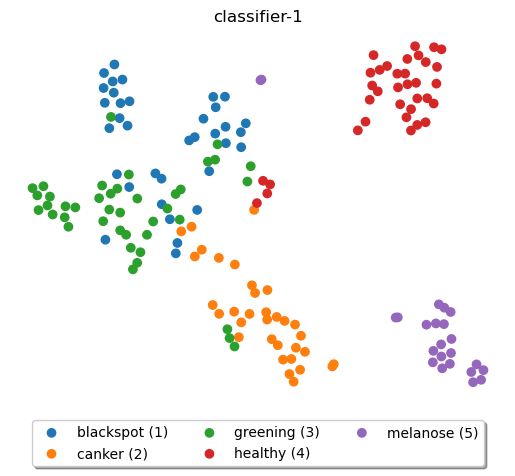

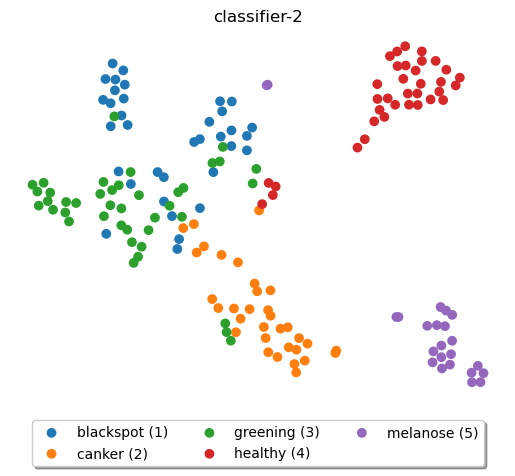

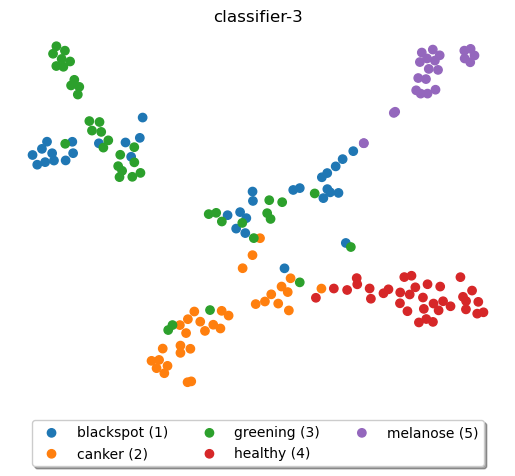

In [24]:
# Dataloaders
train_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=True
)
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=test_images,
    augmentation=False
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[512, 5],
    activations_path=data_path / Path("Exper/FLIM_Freeze_Encoder")
)
load_FLIM_encoder(
    model=model,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 1, 1, 1])).to("cuda")
train_loop(
    200, model, train_dataloader, 1e-4, loss_function, 100,
    freeze_encoder=True, use_lr_scheduler=False
)

# Evaluates our trained Model
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

# Visualize activation projections
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 5.999  trn_accuracy: 0.434  (32.32s - 6431.16s remaining)
EPOCH: 2.000  trn_loss: 1.179  trn_accuracy: 0.628  (62.56s - 6193.77s remaining)
EPOCH: 3.000  trn_loss: 0.810  trn_accuracy: 0.694  (93.39s - 6132.36s remaining)
EPOCH: 4.000  trn_loss: 0.760  trn_accuracy: 0.709  (124.63s - 6106.97s remaining)
EPOCH: 5.000  trn_loss: 0.701  trn_accuracy: 0.730  (156.32s - 6096.53s remaining)
EPOCH: 6.000  trn_loss: 0.634  trn_accuracy: 0.761  (188.32s - 6088.89s remaining)
EPOCH: 7.000  trn_loss: 0.607  trn_accuracy: 0.786  (220.34s - 6075.15s remaining)
EPOCH: 8.000  trn_loss: 0.607  trn_accuracy: 0.767  (253.17s - 6076.08s remaining)
EPOCH: 9.000  trn_loss: 0.587  trn_accuracy: 0.780  (285.82s - 6065.68s remaining)
EPOCH: 10.000  trn_loss: 0.558  trn_accuracy: 0.785  (318.53s - 6052.01s remaining)
EPOCH: 11.000  trn_loss: 0.556  trn_accuracy: 0.783

100%|██████████| 657/657 [02:50<00:00,  3.85it/s]


EPOCH: 101.000  trn_loss: 0.127  trn_accuracy: 0.965  (3641.92s - 3569.81s remaining)
EPOCH: 102.000  trn_loss: 0.146  trn_accuracy: 0.964  (3676.45s - 3532.27s remaining)
EPOCH: 103.000  trn_loss: 0.163  trn_accuracy: 0.962  (3715.17s - 3498.75s remaining)
EPOCH: 104.000  trn_loss: 0.142  trn_accuracy: 0.971  (3752.13s - 3463.51s remaining)
EPOCH: 105.000  trn_loss: 0.137  trn_accuracy: 0.970  (3789.05s - 3428.19s remaining)
EPOCH: 106.000  trn_loss: 0.136  trn_accuracy: 0.977  (3826.66s - 3393.45s remaining)
EPOCH: 107.000  trn_loss: 0.145  trn_accuracy: 0.964  (3860.21s - 3355.14s remaining)
EPOCH: 108.000  trn_loss: 0.125  trn_accuracy: 0.973  (3893.64s - 3316.80s remaining)
EPOCH: 109.000  trn_loss: 0.128  trn_accuracy: 0.976  (3927.45s - 3278.88s remaining)
EPOCH: 110.000  trn_loss: 0.116  trn_accuracy: 0.974  (3960.33s - 3240.27s remaining)
EPOCH: 111.000  trn_loss: 0.144  trn_accuracy: 0.962  (3993.74s - 3202.19s remaining)
EPOCH: 112.000  trn_loss: 0.125  trn_accuracy: 0.970  

100%|██████████| 657/657 [00:29<00:00, 22.64it/s]


[INFO] Metrics for train dataset


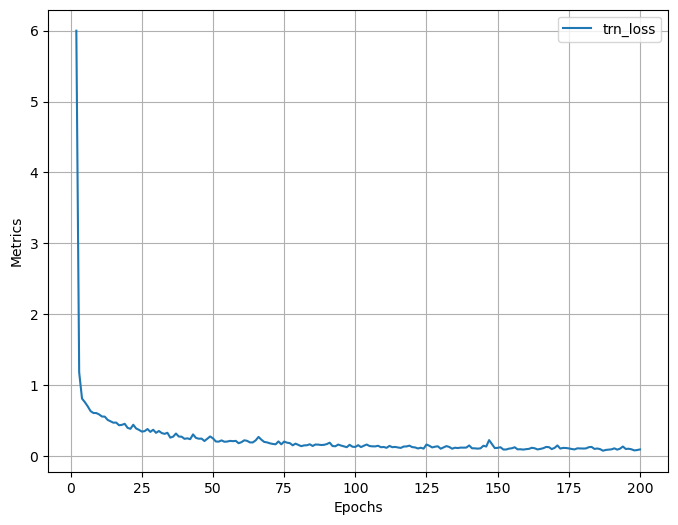

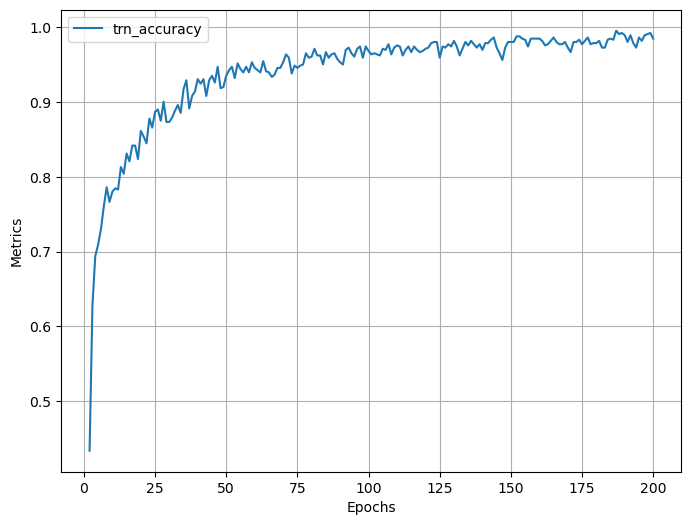

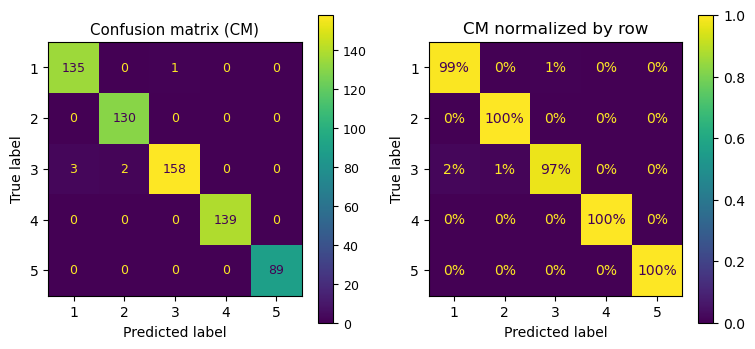

              precision    recall  f1-score   support

   blackspot       0.98      0.99      0.99       136
      canker       0.98      1.00      0.99       130
    greening       0.99      0.97      0.98       163
     healthy       1.00      1.00      1.00       139
    melanose       1.00      1.00      1.00        89

    accuracy                           0.99       657
   macro avg       0.99      0.99      0.99       657
weighted avg       0.99      0.99      0.99       657



100%|██████████| 167/167 [00:08<00:00, 20.73it/s]


[INFO] Metrics for test dataset


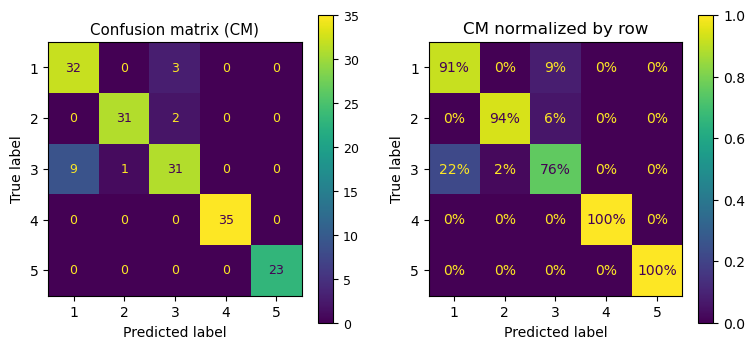

              precision    recall  f1-score   support

   blackspot       0.78      0.91      0.84        35
      canker       0.97      0.94      0.95        33
    greening       0.86      0.76      0.81        41
     healthy       1.00      1.00      1.00        35
    melanose       1.00      1.00      1.00        23

    accuracy                           0.91       167
   macro avg       0.92      0.92      0.92       167
weighted avg       0.91      0.91      0.91       167

[INFO] Generating visualizations for Train dataset


100%|██████████| 83/83 [00:47<00:00,  1.76it/s]


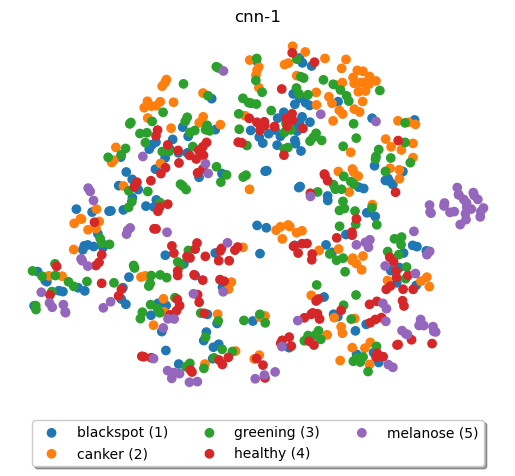

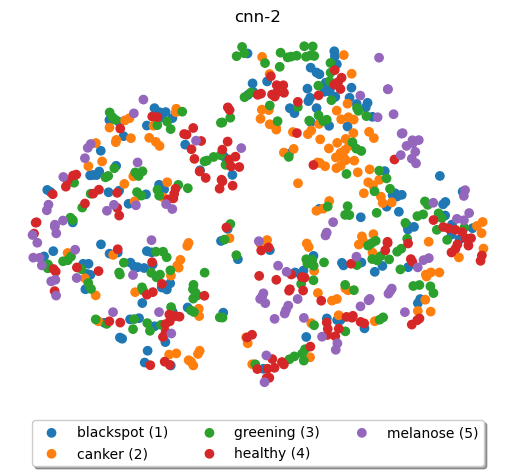

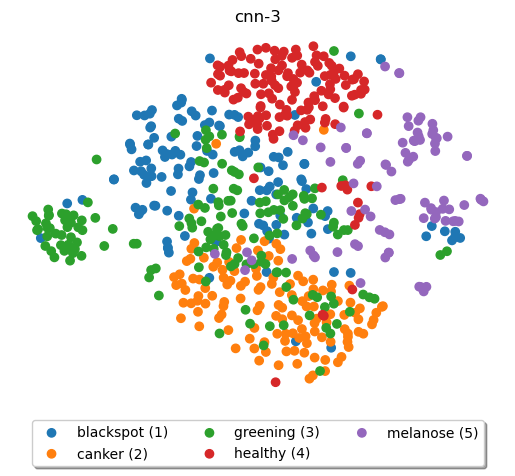

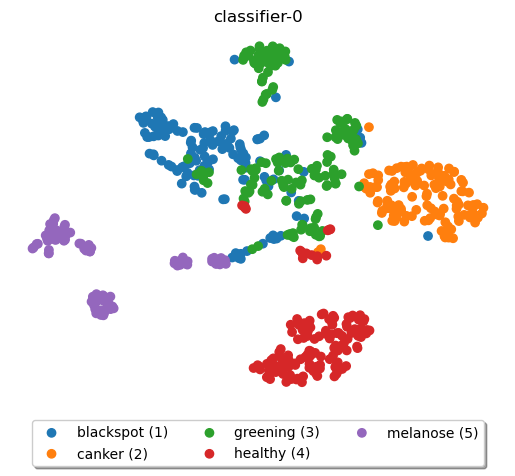

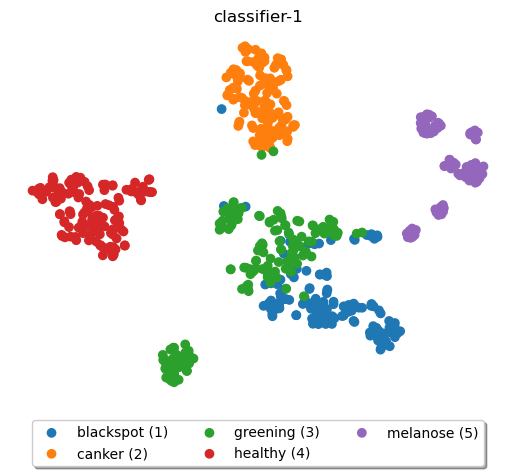

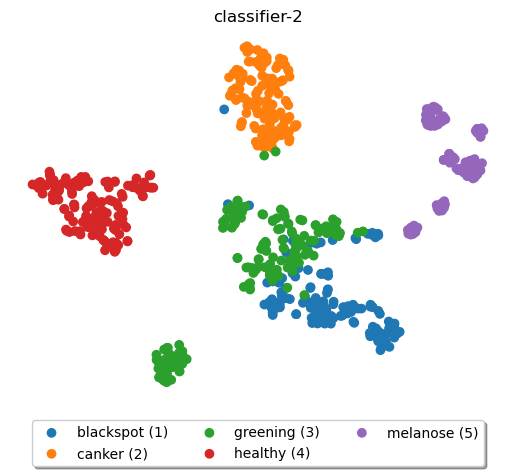

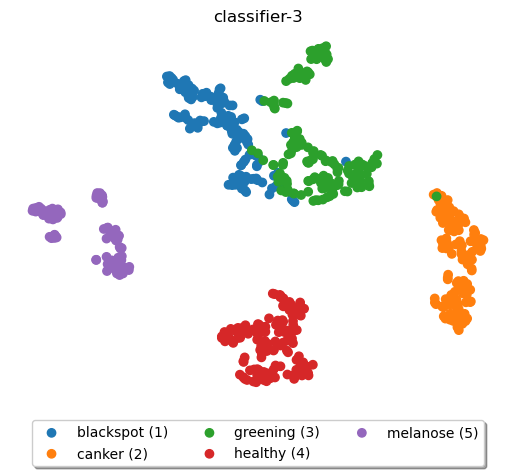

[INFO] Generating visualizations for Test dataset


100%|██████████| 167/167 [00:16<00:00, 10.09it/s]


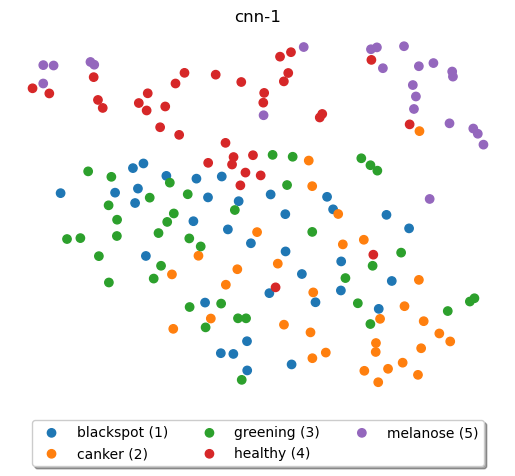

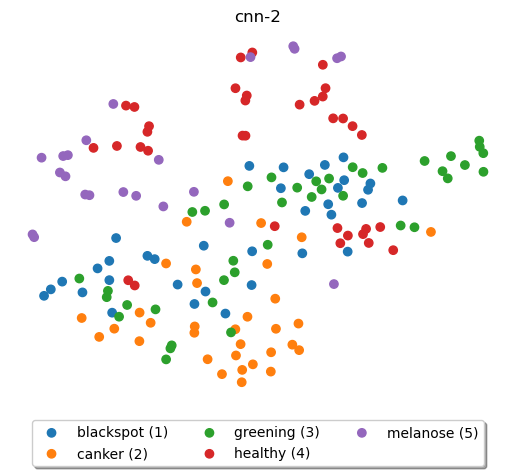

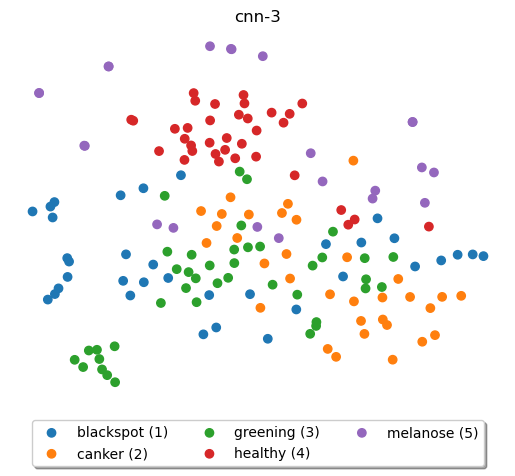

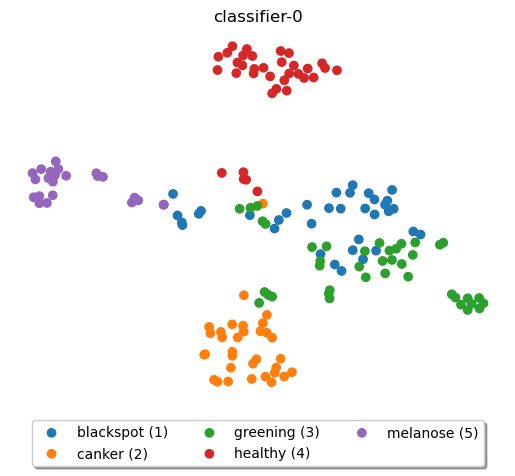

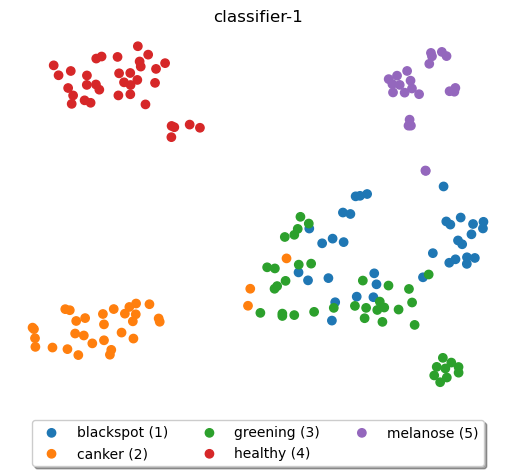

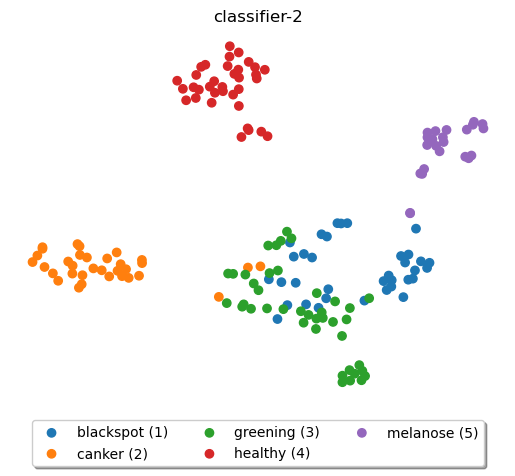

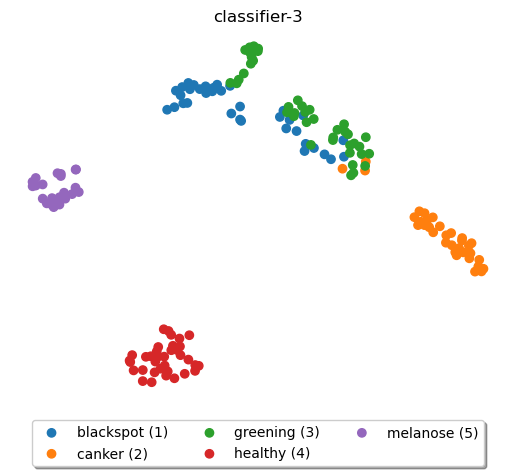

In [25]:
# Dataloaders
train_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=True
)
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=test_images,
    augmentation=False
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[512, 5],
    activations_path=data_path / Path("Exper/FLIM_LR_Fixed")
)
load_FLIM_encoder(
    model=model,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 1, 1, 1])).to("cuda")
train_loop(
    200, model, train_dataloader, 1e-4, loss_function, 100,
    freeze_encoder=False, use_lr_scheduler=False
)

# Evaluates our trained Model
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

# Visualize activation projections
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
EPOCH: 1.000  trn_loss: 4.888  trn_accuracy: 0.242  (30.34s - 6038.40s remaining)
EPOCH: 2.000  trn_loss: 3.876  trn_accuracy: 0.274  (60.95s - 6033.57s remaining)
EPOCH: 3.000  trn_loss: 3.067  trn_accuracy: 0.336  (95.88s - 6295.84s remaining)
EPOCH: 4.000  trn_loss: 2.336  trn_accuracy: 0.416  (131.53s - 6444.79s remaining)
EPOCH: 5.000  trn_loss: 1.903  trn_accuracy: 0.503  (167.26s - 6523.28s remaining)
EPOCH: 6.000  trn_loss: 1.702  trn_accuracy: 0.545  (204.23s - 6603.29s remaining)
EPOCH: 7.000  trn_loss: 1.479  trn_accuracy: 0.595  (236.06s - 6508.45s remaining)
EPOCH: 8.000  trn_loss: 1.364  trn_accuracy: 0.602  (268.17s - 6435.97s remaining)
EPOCH: 9.000  trn_loss: 1.254  trn_accuracy: 0.620  (301.30s - 6394.15s remaining)
EPOCH: 10.000  trn_loss: 1.200  trn_accuracy: 0.649  (340.29s - 6465.42s remaining)
EPOCH: 11.000  trn_loss: 1.160  trn_accuracy: 0.660

100%|██████████| 657/657 [02:18<00:00,  4.76it/s]


EPOCH: 101.000  trn_loss: 0.222  trn_accuracy: 0.937  (3712.75s - 3639.23s remaining)
EPOCH: 102.000  trn_loss: 0.245  trn_accuracy: 0.923  (3754.36s - 3607.13s remaining)
EPOCH: 103.000  trn_loss: 0.194  trn_accuracy: 0.953  (3789.74s - 3568.98s remaining)
EPOCH: 104.000  trn_loss: 0.191  trn_accuracy: 0.956  (3826.53s - 3532.18s remaining)
EPOCH: 105.000  trn_loss: 0.231  trn_accuracy: 0.935  (3866.89s - 3498.61s remaining)
EPOCH: 106.000  trn_loss: 0.229  trn_accuracy: 0.926  (3904.82s - 3462.77s remaining)
EPOCH: 107.000  trn_loss: 0.185  trn_accuracy: 0.946  (3941.29s - 3425.60s remaining)
EPOCH: 108.000  trn_loss: 0.199  trn_accuracy: 0.944  (3978.39s - 3389.00s remaining)
EPOCH: 109.000  trn_loss: 0.168  trn_accuracy: 0.965  (4013.88s - 3351.03s remaining)
EPOCH: 110.000  trn_loss: 0.157  trn_accuracy: 0.961  (4048.23s - 3312.19s remaining)
EPOCH: 111.000  trn_loss: 0.151  trn_accuracy: 0.965  (4081.77s - 3272.77s remaining)
EPOCH: 112.000  trn_loss: 0.206  trn_accuracy: 0.949  

100%|██████████| 657/657 [00:36<00:00, 18.24it/s]


[INFO] Metrics for train dataset


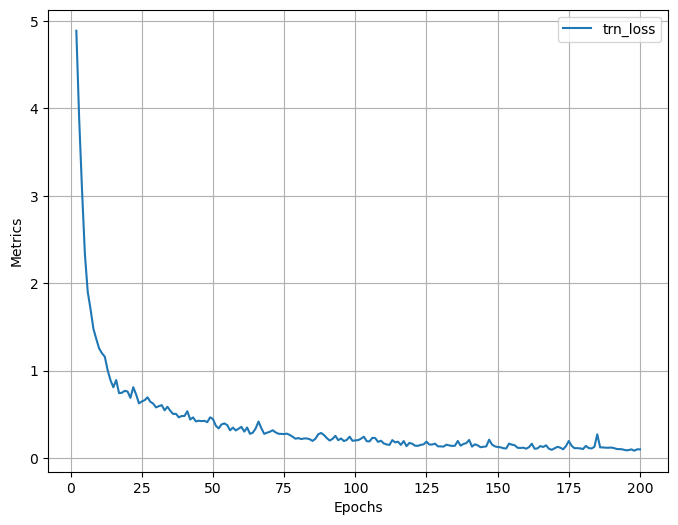

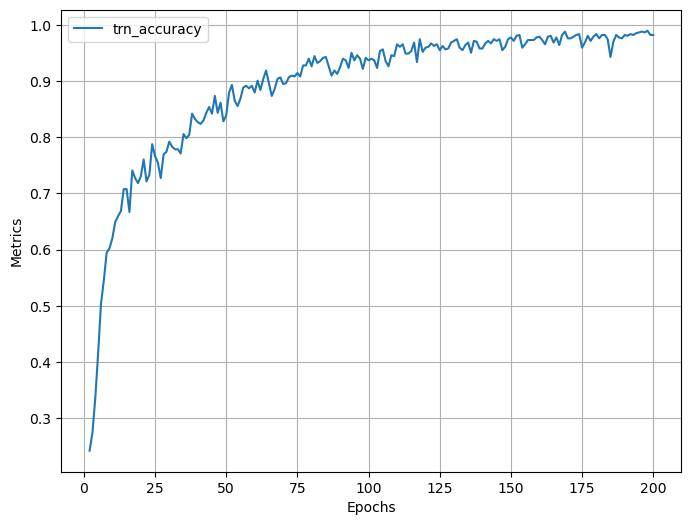

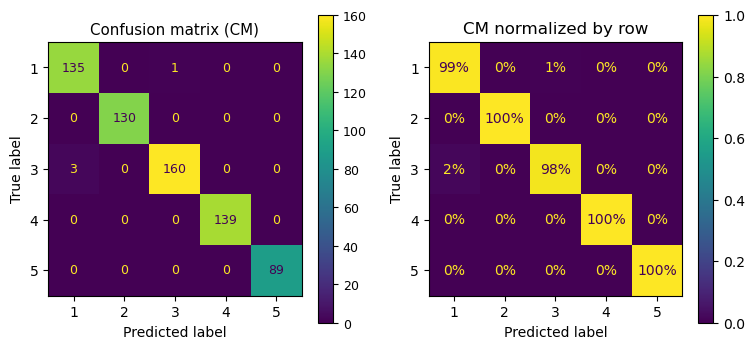

              precision    recall  f1-score   support

   blackspot       0.98      0.99      0.99       136
      canker       1.00      1.00      1.00       130
    greening       0.99      0.98      0.99       163
     healthy       1.00      1.00      1.00       139
    melanose       1.00      1.00      1.00        89

    accuracy                           0.99       657
   macro avg       0.99      0.99      0.99       657
weighted avg       0.99      0.99      0.99       657



100%|██████████| 167/167 [00:07<00:00, 21.41it/s]


[INFO] Metrics for test dataset


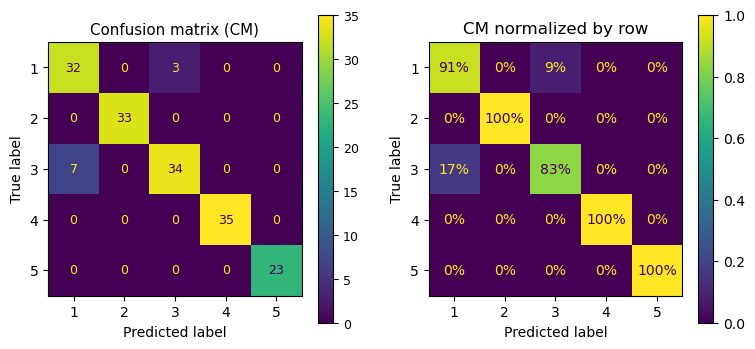

              precision    recall  f1-score   support

   blackspot       0.82      0.91      0.86        35
      canker       1.00      1.00      1.00        33
    greening       0.92      0.83      0.87        41
     healthy       1.00      1.00      1.00        35
    melanose       1.00      1.00      1.00        23

    accuracy                           0.94       167
   macro avg       0.95      0.95      0.95       167
weighted avg       0.94      0.94      0.94       167

[INFO] Generating visualizations for Train dataset


100%|██████████| 83/83 [00:48<00:00,  1.72it/s]


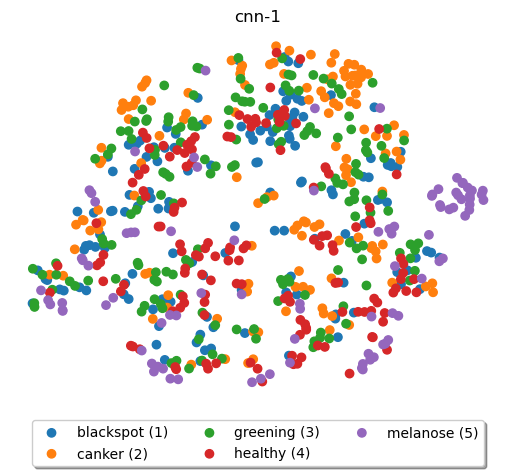

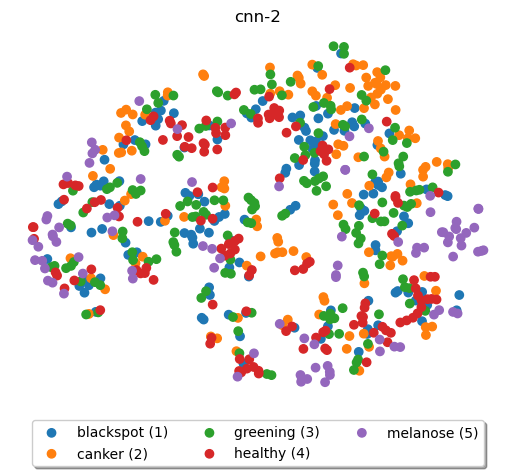

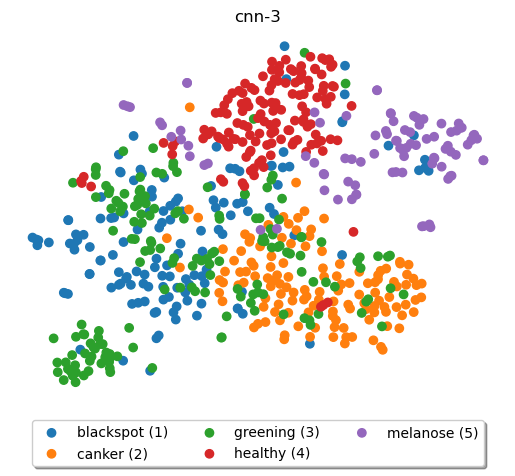

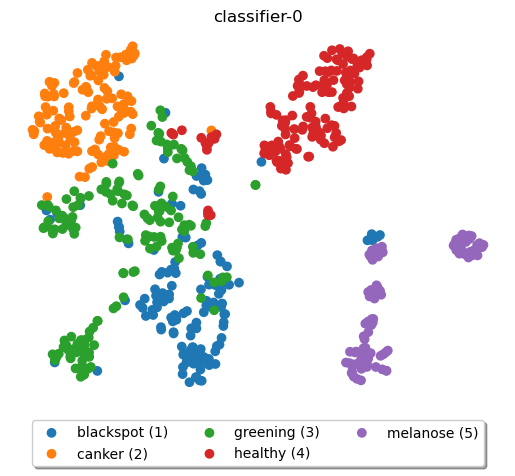

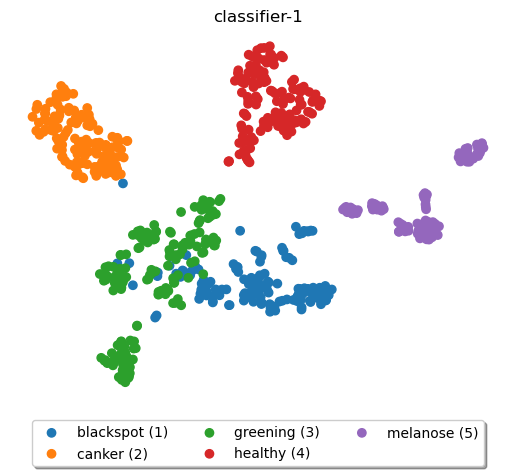

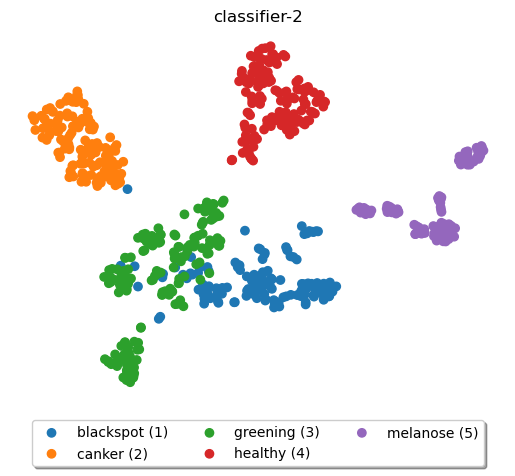

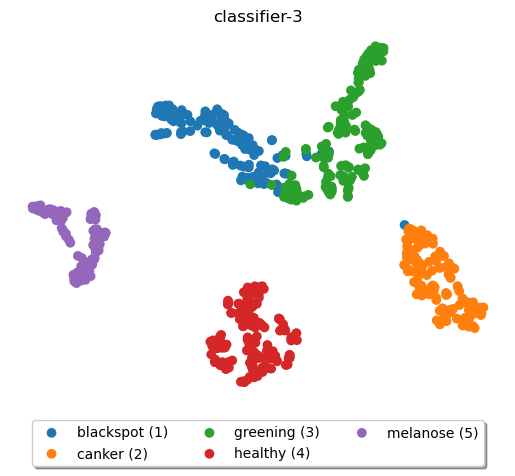

[INFO] Generating visualizations for Test dataset


100%|██████████| 167/167 [00:16<00:00,  9.85it/s]


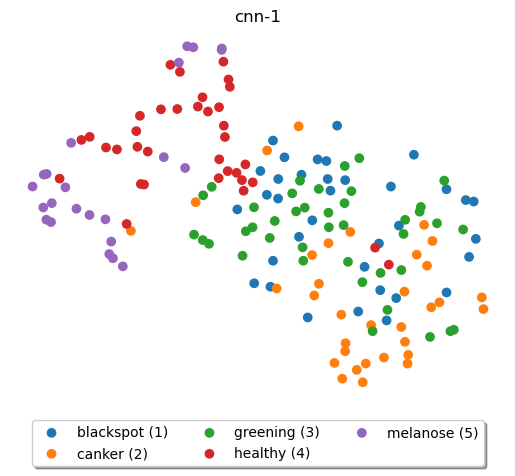

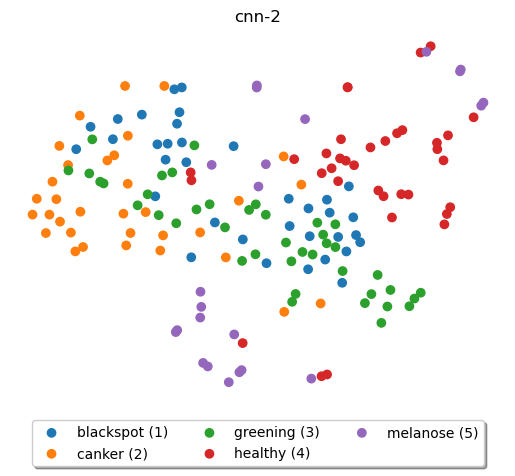

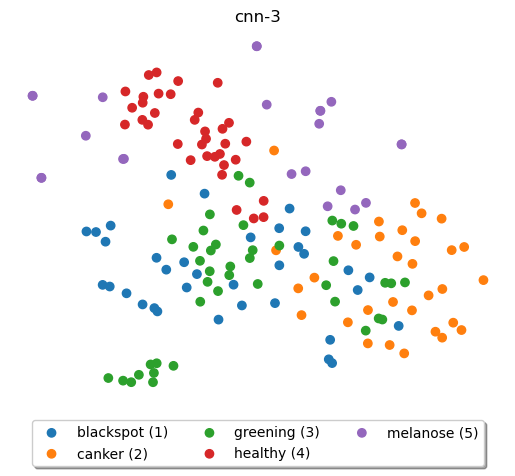

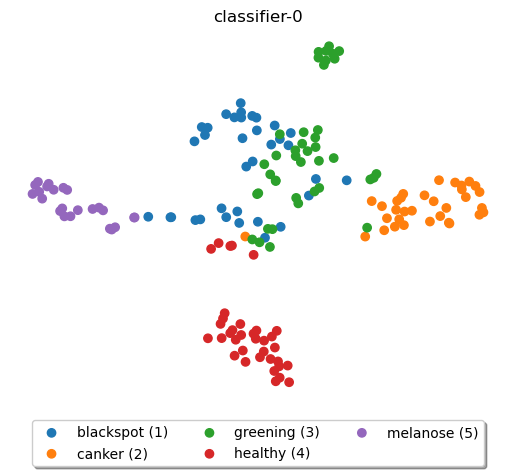

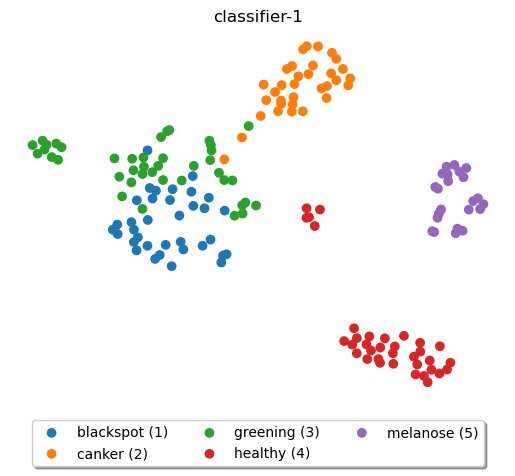

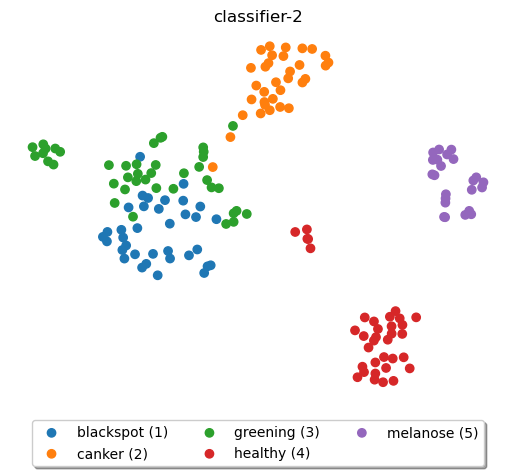

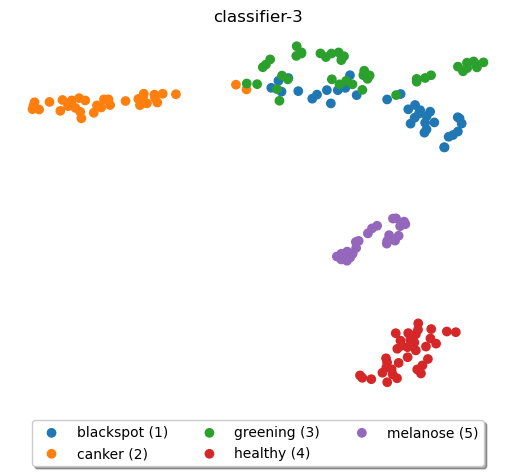

In [26]:
# Dataloaders
train_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=True
)
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=test_images,
    augmentation=False
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[512, 5],
    activations_path=data_path / Path("Exper/FLIM_LR_Scheduler")
)
load_FLIM_encoder(
    model=model,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 1, 1, 1])).to("cuda")
train_loop(
    200, model, train_dataloader, 1e-4, loss_function, 100,
    freeze_encoder=False, use_lr_scheduler=True
)

# Evaluates our trained Model
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

# Visualize activation projections
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

Finally, we will load our model and use an SVM to classify our images:

In [31]:
from sklearn import svm

In [62]:
# Dataloaders
train_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=train_images,
    augmentation=False
)
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=False
)
test_dataset = ClassificationDataset(
    images_folder=images_folder,
    images=test_images,
    augmentation=False
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)
model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[512, 5],
    activations_path=None
)
load_FLIM_encoder(
    model=model,
    arch_json=arch_json,
    weights_path=weights_path,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


In [63]:
# Look for Falcão implementation
@torch.no_grad()
def train_svm(model, dataloader, max_iter=10000, C=100, degree=5):
    print("[INFO] Initializing SVM")
    clf = svm.SVC(
       max_iter=max_iter,
        C=C,
        degree=degree,
        gamma="auto",
        coef0=0,
        decision_function_shape="ovo",
        kernel="linear"
    )
    
    model.eval()
    model.to("cuda")
    
    features=torch.Tensor([])
    y = torch.Tensor([]).long()
    print("[INFO] Preparing Data to SVM")
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model.conv1(inputs)
        outputs = model.conv2(outputs)
        outputs = model.conv3(outputs).detach()

        features = torch.cat((features, outputs.cpu()))
        labels = labels.cpu().long()
        labels = np.argmax(labels, axis=1) + 1
        y = torch.cat((y, labels))
        
    print("[INFO] Fitting SVM")
    clf.fit(features.flatten(start_dim=1), y)
    
    print("[INFO] Done")
    
    return clf        

In [64]:
clf = train_svm(
    model=model,
    dataloader=train_dataloader
)

[INFO] Initializing SVM
[INFO] Preparing Data to SVM


100%|██████████| 83/83 [00:31<00:00,  2.65it/s]


[INFO] Fitting SVM
[INFO] Done


In [78]:
@torch.no_grad()
def evaluate_svm(model, clf, dataloader, dataset) -> None:
    model.eval()
    model.to("cuda")
    
    predictions = torch.Tensor([]).long()
    ground_truth = torch.Tensor([]).long()
    print("[INFO] Predicting with SVM")
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model.conv1(inputs)
        outputs = model.conv2(outputs)
        outputs = model.conv3(outputs).detach().cpu()
        outputs = outputs.flatten(start_dim=1)
        pred = clf.predict(outputs)

        labels = labels.cpu().long()
        labels = np.argmax(labels, axis=1) + 1
        ground_truth = torch.cat((ground_truth, labels))
        predictions = torch.cat((predictions, torch.Tensor(pred)))
        
    print(ground_truth.shape)
    print(predictions.shape)
    
    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        ground_truth,
        predictions,
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        ground_truth,
        predictions,
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()
    
    report = classification_report(
        ground_truth,
        predictions,
        target_names=list(classes_dict.values())
    )
    print(report)

[INFO] Predicting with SVM


100%|██████████| 83/83 [00:30<00:00,  2.75it/s]


torch.Size([657])
torch.Size([657])
[INFO] Metrics for train dataset


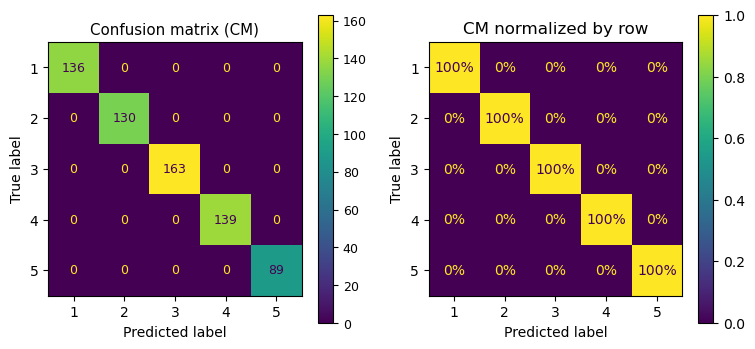

              precision    recall  f1-score   support

   blackspot       1.00      1.00      1.00       136
      canker       1.00      1.00      1.00       130
    greening       1.00      1.00      1.00       163
     healthy       1.00      1.00      1.00       139
    melanose       1.00      1.00      1.00        89

    accuracy                           1.00       657
   macro avg       1.00      1.00      1.00       657
weighted avg       1.00      1.00      1.00       657



In [79]:
evaluate_svm(model=model, clf=clf, dataloader=train_dataloader, dataset="train")

[INFO] Predicting with SVM


100%|██████████| 167/167 [00:07<00:00, 21.53it/s]


torch.Size([167])
torch.Size([167])
[INFO] Metrics for test dataset


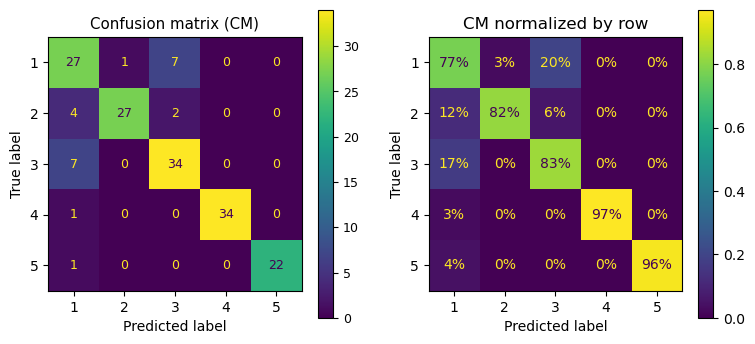

              precision    recall  f1-score   support

   blackspot       0.68      0.77      0.72        35
      canker       0.96      0.82      0.89        33
    greening       0.79      0.83      0.81        41
     healthy       1.00      0.97      0.99        35
    melanose       1.00      0.96      0.98        23

    accuracy                           0.86       167
   macro avg       0.89      0.87      0.88       167
weighted avg       0.87      0.86      0.87       167



In [81]:
evaluate_svm(model=model, clf=clf, dataloader=test_dataloader, dataset="test")

# Extra - Activities

- Modify augmentations, or test without it, and verify model's performance.
- Test different configurations for fully connected layers.
- Test different configurations for SVM
- Test different classifiers (e.g., Decision Trees)